# Puntos de Interés de OpenStreetMap (Geofabrik)

Este notebook carga, limpia y procesa datos geoespaciales de Puntos de Interés (POIs) y Uso de Suelo (Land Use) provenientes de OpenStreetMap (shapefiles de Geofabrik). Los datos se categorizan según su relevancia para el análisis inmobiliario (valor de arriendo/compra), generando capas separadas para cada tipo de equipamiento (educación, salud, comercio, etc.) y zona (residencial, verde, comercial). Incluye un ejemplo de visualización de POIs filtrados por comuna.

In [52]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

In [3]:
#1. Leemos los archivos ShapeFile

# Archivo de POIs como PUNTOS
path_pois = os.path.join("OSM", "gis_osm_pois_free_1.shp")
gdf_pois = gpd.read_file(path_pois)

# Archivo de uso de suelos como POLÍGONOS
path_landuse = os.path.join("OSM", "gis_osm_landuse_a_free_1.shp")
gdf_landuse = gpd.read_file(path_landuse)

In [18]:
#2. Inpeccionamos los datos cargados
print("\nColumnas en POIs:", gdf_pois.columns)
print("Valores únicos de 'fclass' en POIs:", gdf_pois["fclass"].unique())

print("\nColumnas en Landuse:", gdf_landuse.columns)
print("Valores únicos de 'fclass' en Landuse:", gdf_landuse["fclass"].unique())


Columnas en POIs: Index(['osm_id', 'code', 'fclass', 'name', 'geometry'], dtype='object')
Valores únicos de 'fclass' en POIs: ['optician' 'viewpoint' 'pub' 'library' 'attraction' 'ruins' 'pharmacy'
 'hotel' 'camp_site' 'supermarket' 'bank' 'fast_food' 'fire_station'
 'police' 'restaurant' 'convenience' 'track' 'water_tower' 'cafe' 'atm'
 'hospital' 'post_office' 'arts_centre' 'sports_centre' 'museum'
 'doityourself' 'cinema' 'monument' 'chalet' 'battlefield' 'bakery'
 'bicycle_shop' 'artwork' 'hostel' 'swimming_pool' 'clinic'
 'department_store' 'dentist' 'beverages' 'school' 'memorial' 'town_hall'
 'doctors' 'wayside_shrine' 'lighthouse' 'nightclub' 'car_dealership'
 'computer_shop' 'university' 'chemist' 'butcher' 'laundry' 'shelter'
 'theatre' 'tourist_info' 'veterinary' 'college' 'guesthouse'
 'archaeological' 'bar' 'florist' 'waste_basket' 'bicycle_rental' 'tower'
 'comms_tower' 'playground' 'recycling' 'hairdresser' 'kindergarten'
 'picnic_site' 'recycling_glass' 'theme_park' 't

# Limpieza

In [28]:
#1. Eliminamos filas sin geometría válida
gdf_pois = gdf_pois[gdf_pois.is_valid]
gdf_landuse = gdf_landuse[gdf_landuse.is_valid]

#2. Eliminamos valores nulos en columnas clave
gdf_pois = gdf_pois.dropna(subset=["fclass", "name"])
gdf_landuse = gdf_landuse.dropna(subset=["fclass"])

#3. Eliminamos valores duplicados
gdf_pois = gdf_pois.drop_duplicates()
gdf_landuse = gdf_landuse.drop_duplicates()


# Organización por categorias
Crearemos DataFrames por categorias clave.

In [27]:
#1. Definimos las categorias que son relevantes para la estimación del valor de arriendo y/o compra de una propiedad.

#Diccionario para Puntos de Interés (POIs):
categorias_pois = {
    "educacion": [
        "school", "university", "college", "kindergarten", "library"
    ],
    "salud": [
        "pharmacy", "hospital", "clinic", "dentist", "doctors", "nursing_home", 
        "veterinary"
    ],
    "comercio_basico": [
        "supermarket", "convenience", "bakery", "butcher", "greengrocer", 
        "market_place", "kiosk"
    ],
    "comercio_retail": [
        "department_store", "mall", "doityourself", "clothes", "shoe_shop", 
        "sports_shop", "bookshop", "toy_shop", "furniture_shop", "optician",
        "jeweller", "mobile_phone_shop", "computer_shop", "car_dealership"
    ],
    "restauracion": [
        "pub", "fast_food", "restaurant", "cafe", "bar", "food_court", 
        "biergarten"
    ],
    "recreacion_deporte": [
        "sports_centre", "track", "swimming_pool", "pitch", "playground", 
        "golf_course"
    ],
    "cultura_ocio": [
        "attraction", "arts_centre", "museum", "cinema", "monument", 
        "theatre", "zoo", "theme_park", "viewpoint"
    ],
    "servicios_financieros": [
        "bank", "atm"
    ],
    "servicios_generales": [
        "post_office", "laundry", "hairdresser", "community_centre", 
        "town_hall", "public_building", "car_rental", "car_wash"
    ],
    "seguridad": [
        "fire_station", "police", "courthouse"
    ],
    "alojamiento": [
        "hotel", "hostel", "guesthouse", "motel", "camp_site"
    ]
}

In [23]:
#Diccionario para Uso de Suelo (Landuse):
categorias_landuse = {
    "zona_verde_recreacion": [
        "forest", "scrub", "nature_reserve", "park", "grass", "meadow", 
        "recreation_ground"
    ],
    "zona_comercial_retail": [
        "retail", "commercial"
    ],
    "zona_residencial": [
        "residential"
    ],
    "zona_industrial": [
        "industrial", "quarry"
    ],
    "zona_agricola": [
        "farmland", "farmyard", "orchard", "vineyard", "allotments"
    ],
    "zona_servicios_especiales": [
        "cemetery", "military"
    ]
}

In [29]:
#2. Creamos un GeoDataFrame por cada categoria:
gdf_salud = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["salud"])]
gdf_educacion = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["educacion"])]
gdf_comercio_basico = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["comercio_basico"])]
gdf_comercio_retail = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["comercio_retail"])]
gdf_restauracion = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["restauracion"])]
gdf_recreacion_deporte = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["recreacion_deporte"])]
gdf_cultura_ocio = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["cultura_ocio"])]
gdf_servicios_financieros = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["servicios_financieros"])]
gdf_servicios_generales = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["servicios_generales"])]
gdf_seguridad = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["seguridad"])]
gdf_alojamiento = gdf_pois[gdf_pois["fclass"].isin(categorias_pois["alojamiento"])]

In [30]:
#3. Análogamente, creamos GeoDataFrames para las categorias de uso de suelo:
gdf_zona_verde_recreacion = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_verde_recreacion"])]
gdf_zona_comercial_retail = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_comercial_retail"])]
gdf_zona_residencial = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_residencial"])]
gdf_zona_industrial = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_industrial"])]
gdf_zona_agricola = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_agricola"])]
gdf_zona_servicios_espec = gdf_landuse[gdf_landuse["fclass"].isin(categorias_landuse["zona_servicios_especiales"])]


# Mapa de POI´s
A modo de ejemplo, graficamos únicamente los puntos de interés con categoria de restauración dentro de la comuna de Providencia.

In [35]:
gdf_restauracion.head()

,osm_id,code,fclass,name,geometry
2,133663460,2304,pub,Bar Ciudadano,POINT (-70.62849 -33.44622)
27,253282924,2302,fast_food,McDonald's,POINT (-70.84179 -33.44026)
42,256610696,2301,restaurant,Café Journal,POINT (-71.56288 -33.02492)
43,256610857,2304,pub,Alcazaba,POINT (-71.55782 -33.0183)
44,256610876,2304,pub,Buffalo,POINT (-71.55769 -33.01832)


In [32]:
#1. Verificamos el CRS del GeoDataFrame.
print("CRS:", gdf_restauracion.crs)

CRS: EPSG:4326


In [33]:
#2. Cargamos el shapefile con las comunas de Chile
path_comunas = os.path.join("Comunas", "Comunas.shp")
comunas = gpd.read_file(path_comunas)

#4. Verificamos el CRS del shapefile
print("CRS:", comunas.crs)

CRS: EPSG:3857


In [36]:
#5. Como el CRS de las comunas no es EPSG:4326, lo modificamos
comunas = comunas.to_crs("EPSG:4326")

print("CRS final:", comunas.crs)

CRS final: EPSG:4326


In [43]:
#6. Filtramos el shapefile para la comuna de Providencia
mapa_providencia = comunas[comunas["Comuna"] == "Providencia"].copy()

#7. Filtramos los POI´s de restauración dentro de la comuna de Providencia
gdf_restauracion_providencia = gpd.sjoin(gdf_restauracion, mapa_providencia, how = 'inner')

gdf_restauracion_providencia.head()

,osm_id,code,fclass,name,geometry,index_right,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia
2,133663460,2304,pub,Bar Ciudadano,POINT (-70.62849 -33.44622),82,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago
443,390992649,2301,restaurant,Macharoas,POINT (-70.5935 -33.42806),82,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago
468,403750649,2302,fast_food,McDonald's,POINT (-70.60153 -33.41863),82,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago
469,403750651,2302,fast_food,Domino,POINT (-70.6015 -33.41877),82,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago
471,403750884,2302,fast_food,Sushi,POINT (-70.59874 -33.42072),82,324,16072.408276,10,7,13123,13,2.073083e+07,19223.740933,Región Metropolitana de Santiago,Providencia,Santiago


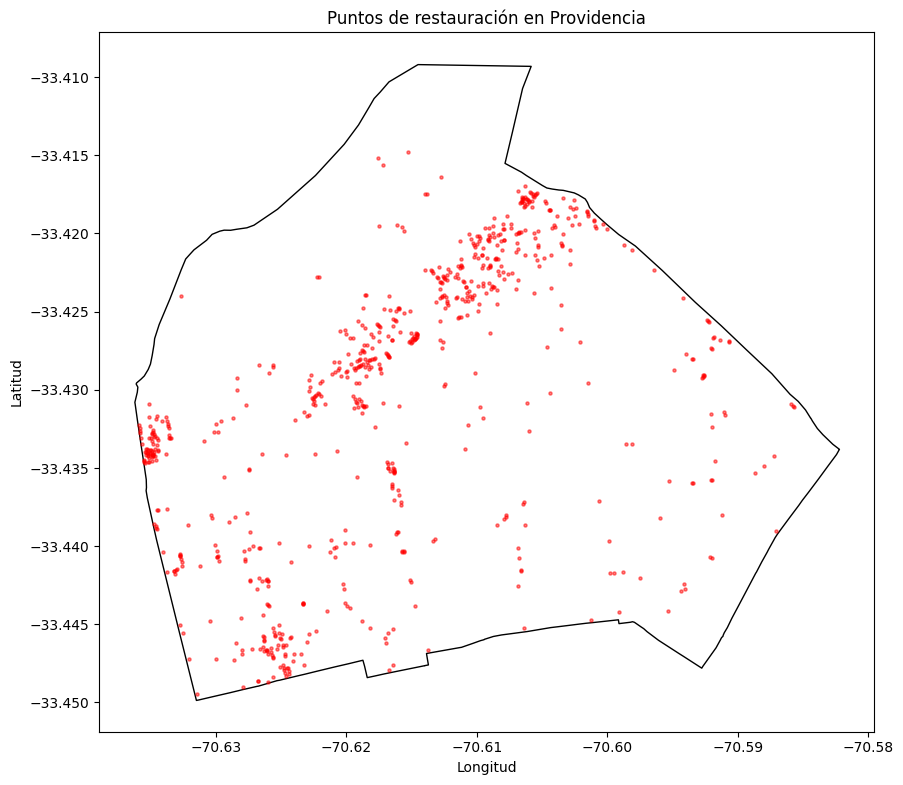

In [44]:
#8. Graficamos los POI´s de restauración en la comuna de Providencia
fig, ax = plt.subplots(figsize = (10, 10))

# Dibujar mapa base de regiones
mapa_providencia.plot(ax = ax, color = "white", edgecolor = "black")

# Dibujar puntos de restauración
gdf_restauracion_providencia.plot(ax = ax, markersize = 5, color = "red", alpha = 0.5)

plt.title("Puntos de restauración en Providencia", fontsize = 12)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

# Mapa de Land Use
A modo de ejemplo, graficamos únicamente las zonas con categoria de áreas verdes de recreación dentro de la comuna de Las Condes.

In [48]:
#1. Filtramos el shapefile para la comuna de Las Condes
mapa_las_condes = comunas[comunas["Comuna"] == "Las Condes"].copy()

#2. Filtramos las zonas de áreas verdes de recreación dentro de la comuna de Las Condes
gdf_zona_verde_recreacion_las_condes = gpd.sjoin(gdf_zona_verde_recreacion, mapa_las_condes, how = 'inner')

gdf_zona_verde_recreacion_las_condes.head()

,osm_id,code,fclass,name,geometry,index_right,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia
48,22371383,7202,park,Parque Araucano,"POLYGON ((-70.57992 -33.40418, -70.57907 -33.4...",156,315,51230.563241,11,7,13114,13,1.416658e+08,61618.090148,Región Metropolitana de Santiago,Las Condes,Santiago
52,23168146,7202,park,Plaza Cumbres de San Juan,"POLYGON ((-70.50787 -33.39341, -70.50756 -33.3...",156,315,51230.563241,11,7,13114,13,1.416658e+08,61618.090148,Región Metropolitana de Santiago,Las Condes,Santiago
56,23351490,7202,park,Plaza Horacio Rivarola,"POLYGON ((-70.57091 -33.42068, -70.57087 -33.4...",156,315,51230.563241,11,7,13114,13,1.416658e+08,61618.090148,Región Metropolitana de Santiago,Las Condes,Santiago
57,23351694,7202,park,Plaza Perú,"POLYGON ((-70.599 -33.41489, -70.59895 -33.414...",156,315,51230.563241,11,7,13114,13,1.416658e+08,61618.090148,Región Metropolitana de Santiago,Las Condes,Santiago
58,23361892,7202,park,Plaza Juan Pablo II,"POLYGON ((-70.5794 -33.42664, -70.57937 -33.42...",156,315,51230.563241,11,7,13114,13,1.416658e+08,61618.090148,Región Metropolitana de Santiago,Las Condes,Santiago


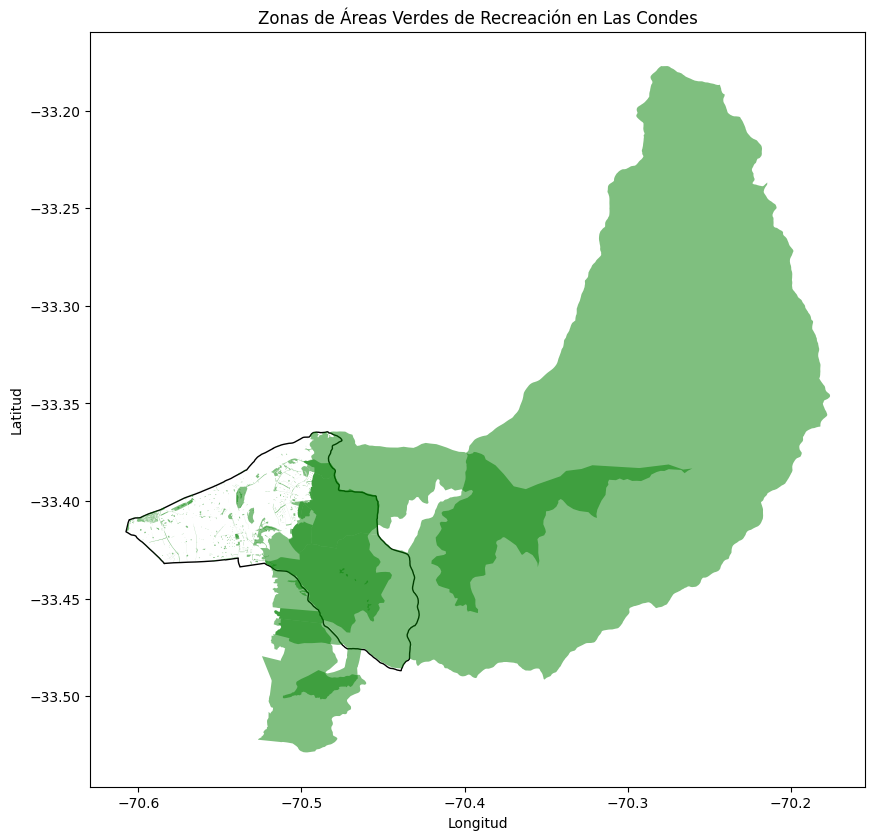

In [56]:
#3. Graficamos las zonas de áreas verdes de recreación en la comuna de Las Condes
fig, ax = plt.subplots(figsize = (10, 10))

#Dibujar mapa base de Las Condes
mapa_las_condes.plot(ax = ax, color = "white", edgecolor = "black")

#Dibujar zonas de áreas verdes de recreación
gdf_zona_verde_recreacion_las_condes.plot(ax = ax, color = 'green', alpha = 0.5)

plt.title("Zonas de Áreas Verdes de Recreación en Las Condes", fontsize = 12)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()